# Loading in packages

In [1]:
# # Installing packages
# using Pkg
# Pkg.add(["CairoMakie", "CSV", "DataFrames", "GeneticsMakie", "SnpArrays"])

In [2]:
# Loading packages
using CairoMakie, CSV, DataFrames, GeneticsMakie, SnpArrays

# Loading in data

In [5]:
# Filenames
pops = ["eur", "amr", "afr", "mixed"]
summarystatsfilenames = [joinpath("/u/project/gandalm/cindywen/isoform_twas/eqtl_new",
                              "locuszoom/MTFR1/$(pop)_ENSG00000066855_all_assoc.txt")
                     for pop in pops]
gencodefilename = joinpath("/u/project/gandalm/shared/refGenomes/hg19/Gencode/v33",
                           "gencode.v33lift37.annotation.gtf")
genotypefilenames = [joinpath("/u/project/gandalm/cindywen/isoform_twas/genotype",
                              "all_data/isec_R2_greater_than_3/ancestry/$(pop)",
                              "filtered.hg19.sorted")
                     for pop in pops]
mixedgenotypefilename = joinpath("/u/project/gandalm/cindywen/isoform_twas/genotype",
                                 "all_data/isec_R2_greater_than_3/ancestry",
                                 "filtered.hg19.sorted")
genotypefilenames[4] = mixedgenotypefilename

"/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted"

In [6]:
# DataFrames
summarystatsdfs = CSV.read.(summarystatsfilenames, DataFrame;
                            header = ["geneid", "snpid", "distance", "nominal",
                                      "beta", "p"])
gencode = CSV.read(gencodefilename, DataFrame;
                   delim = "\t", comment = "#",
                   header = ["seqnames", "source", "feature", "start", "end", "score", 
                             "strand", "phase", "info"])
GeneticsMakie.parsegtf!(gencode)
select!(gencode,
        :seqnames, :feature, :start, :end, :strand,
        :gene_name, :gene_type, :transcript_id)

,seqnames,feature,start,end,strand,gene_name,gene_type
,String,String15,Int64,Int64,String1,SubStrin…,SubStrin…
1,1,gene,11869,14409,+,DDX11L1,transcribed_unprocessed_pseudogene
2,1,transcript,11869,14409,+,DDX11L1,transcribed_unprocessed_pseudogene
3,1,exon,11869,12227,+,DDX11L1,transcribed_unprocessed_pseudogene
4,1,exon,12613,12721,+,DDX11L1,transcribed_unprocessed_pseudogene
5,1,exon,13221,14409,+,DDX11L1,transcribed_unprocessed_pseudogene
6,1,transcript,12010,13670,+,DDX11L1,transcribed_unprocessed_pseudogene
7,1,exon,12010,12057,+,DDX11L1,transcribed_unprocessed_pseudogene
8,1,exon,12179,12227,+,DDX11L1,transcribed_unprocessed_pseudogene
9,1,exon,12613,12697,+,DDX11L1,transcribed_unprocessed_pseudogene


In [7]:
# SnpData
genotypesnpdatas = [SnpData(genof) for genof in genotypefilenames]

4-element Vector{SnpData}:
 SnpData(people: 292, snps: 6381990,
snp_info: 
 Row │ chromosome  snpid        genetic_distance  position  allele1  allele2
     │ String      String       Float64           Int64     String   String
─────┼───────────────────────────────────────────────────────────────────────
   1 │ 1           rs61769339                0.0    662622  A        G
   2 │ 1           rs12238997                0.0    693731  G        A
   3 │ 1           rs61769351                0.0    693823  C        G
   4 │ 1           rs142559957               0.0    704637  A        G
   5 │ 1           rs58276399                0.0    731718  C        T
   6 │ 1           rs61770163                0.0    732032  C        A
…,
person_info: 
 Row │ fid        iid        father     mother     sex        phenotype
     │ Abstract…  Abstract…  Abstract…  Abstract…  Abstract…  Abstract…
─────┼──────────────────────────────────────────────────────────────────
   1 │ 898        898        0    

In [8]:
# Pre-processing data
summarystatsdfs = [innerjoin(select(genotypesnpdatas[4].snp_info,
                                    :chromosome, :snpid, :position),
                             df; on = :snpid) for df in summarystatsdfs]
GeneticsMakie.mungesumstats!(summarystatsdfs)

LoadError: ArgumentError: column name :Z not found in the data frame; existing most similar names are: :P and :BP

# Plotting LocusZoom plots

Set the SNP ID you want a plot of in the first cell below

In [7]:
snpid = "rs68167505"

"rs68167505"

In [8]:
# Finding locus
chr = subset(genotypesnpdatas[4].snp_info,
                    :snpid => col -> col .== snpid)[1, :chromosome]
start = subset(genotypesnpdatas[4].snp_info,
                    :snpid => col -> col .== snpid)[1, :position]
stop = start
range1 = start - 1e6
range2 = stop + 1e6
n = length(pops)
titles = ["EUR", "AMR", "AFR", "Mixed"]
println(subset(genotypesnpdatas[4].snp_info, :snpid => col -> col .== snpid))


1×6 DataFrame
 Row │ chromosome  snpid       genetic_distance  position  allele1  allele2 
     │ String      String      Float64           Int64     String   String  
─────┼──────────────────────────────────────────────────────────────────────
   1 │ 8           rs68167505               0.0  66557533  C        T


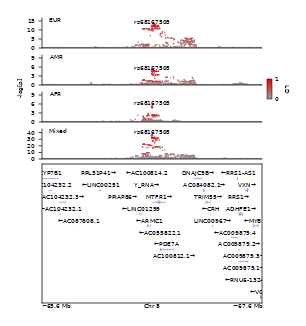

In [9]:
# Plotting locuszoom plots
CairoMakie.activate!(type = "png")
f = Figure(resolution = (306, 792))
axs = [Axis(f[i, 1]) for i in 1:(1 + length(pops))]
for i in 1:n
    ldfilename = tempname()
    SnpArrays.filter(genotypefilenames[i],
                     1:size(genotypesnpdatas[i].snparray, 1),
                     findall(row -> row.chromosome == chr &&
                             range1 <= row.position <= range2,
                             eachrow(genotypesnpdatas[i].snp_info));
                     des = ldfilename)
    GeneticsMakie.plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
                             ld = (SnpData(ldfilename), snpid))
    rowsize!(f.layout, i, 30)
    Label(f[i, 1, Top()], titles[i];
          textsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
end
rs = GeneticsMakie.plotgenes!(axs[n + 1], chr, range1, range2, gencode; height = 0.1)
rowsize!(f.layout, n + 1, rs)
GeneticsMakie.labelgenome(f[n + 1, 1, Bottom()], chr, range1, range2)
Colorbar(f[1:n, 2], limits = (0, 1), ticks = 0:1:1, height = 20,
         colormap = (:gray60, :red2), label = "LD", ticksize = 0, tickwidth = 0,
         tickalign = 0, ticklabelsize = 6, flip_vertical_label = true,
         labelsize = 6, width = 5, spinewidth = 0.5)
Label(f[1:n, 0], text = "-log[p]", textsize = 6, rotation = pi / 2)
rowgap!(f.layout, 5)
colgap!(f.layout, 5)
resize_to_layout!(f)
f

# Save file

Set filename in cell below

In [10]:
CairoMakie.activate!(type = "png")
outputfilename = ""
# save(filename, f, px_per_unit = 4)

""